# Approximate Inference in probabilistic modeling

## 1. Introduction

Exact inference in probabilistic models is usually not possible, due to intractability of expectations or any other quantity involving integrals which are not analytically computable. Hence, algorithms which are able to perform inference approximately, are widely used. 2 main classes of approximate inference algorithms are Variational Inference (VI) based methods, and Sampling based methods.

In this notebook, emphasis will be on demonstrating the efficiency and usefulness of such approximate inference algorithms for probabilistic modeling tasks. 

## 2. Sampling based methods
### 2.1 Rejection Sampling

The most basic algorithm used to sample from a distribution which is not fully tractable, is **Rejection Sampling**. Consider a probability distribution $p(x) = \frac{\tilde{p}(x)}{Z_p}$, where $Z_p$ is intractable. However, we can evaluate $\tilde{p}(x) \,\, \forall x \, \in \, \text{Support}(\tilde{p}(x))$.
The algorithm is simple : At every iteration $t$, we sample $x^{(t)}$ from a proposal distribution $q(x)$ and $u$ from $U[0, Mq(x)]$, where M is a constant such that $Mq(x) > \tilde{p}(x) \,\, \forall x \, \in \, \text{Support}(\tilde{p}(x))$. The support of the proposal distribution should be atleast the support of $\tilde{p}(x)$. 

If $u \geq \tilde{p}(x)$, we add $x^{(t)}$ to the set of samples, else it is rejected. 

In [36]:
import numpy as np 
from scipy.special import gamma
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

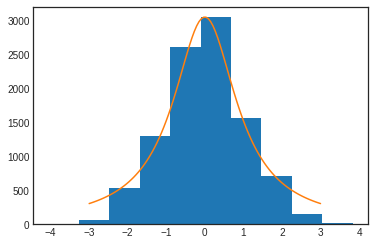

In [37]:
'''1-Dimensional rejection sampling algorithm.
   Try out different p_c (target) distributions and corresponding values of M, q(x)
   to assess convergence time and quality
   Note: Please modify X in plot_histogram as per the distribution being tested
'''

N_SAMPLES = 10000
Q_VAR = 1.0

M = 1

#Cauchy distribution
MU_C, GAMMA = 0, 1

#Normal distribution
MU_N, VAR = 0, 1


def plot_samples(samples, p_c):
    X = np.linspace(-3,3,100)
    p_cX = p_c(X)
    y,_,_ = plt.hist(samples)
    
    C = y.max()/np.max(p_cX)

    plt.plot(X, C*p_cX)
    plt.savefig("sample.png")

def rejection_sampling(p_c, q, M):
    samples = []
    while(len(samples) < N_SAMPLES):
        z = np.random.normal(0.0, np.sqrt(Q_VAR))
        u = np.random.uniform(0.0, M*q(z))
        if u <= p_c(z):
            samples.append(z)
    samples = np.array(samples)

    plot_samples(samples,p_c)

p_cauchy = lambda x: (1/(np.pi * GAMMA)) * ( 1 / ( 1 + ((x-MU_C)/GAMMA) ** 2 ) )
p_normal = lambda x:  (1/np.sqrt(2*np.pi*VAR)) * np.exp(-(1/2*VAR) * (x-MU_N)**2)

q = lambda x: np.exp((-x**2)/(2*Q_VAR)) / np.sqrt(2*np.pi*Q_VAR)

rejection_sampling(p_cauchy, q, M)

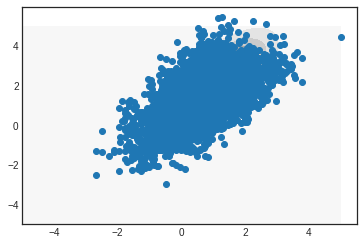

In [43]:
'''2-Dimensional rejection sampling algorithm.
   Try out different p_c (target) distributions and corresponding values of M, q(x)
   to assess convergence time and quality
   Note: Please modify X in plot_histogram as per the distribution being tested
'''
N_SAMPLES = 5000
Q_VAR = 2. #Q_COV = Q_VAR * Identity(2x2)

M = 10

#2D Normal
MU_2D = np.array([1.0,2.0])
COV = np.array([[1,1],
                [1,2]])

def plot_samples(samples, p_c):
    x = np.linspace(-5,5,100)
    y = np.linspace(-5,5,100)
    X, Y = np.mgrid[-5:5:0.01,-5:5:0.01]

    XY = np.dstack((X,Y))
    p_cXY = p_c(XY)

    plt.contourf(X,Y,p_cXY)                 #Comment this line to see samples
    plt.scatter(*zip(*samples))             #Comment this line to see plot of the distribution of interest
    plt.savefig("sample.png")    

def rejection_sampling(p_c, q, M):
    samples = []
    while len(samples) < N_SAMPLES:
        z = np.random.multivariate_normal(np.zeros(2), Q_VAR*np.identity(2))
        u = np.random.uniform(0.0, M*q.pdf(z))
        if u <= p_c(z):
            samples.append(z)
    samples = np.array(samples)

    plot_samples(samples,p_c)


p_normal_2d = multivariate_normal(MU_2D, COV).pdf
q = multivariate_normal(np.zeros((2,)),Q_VAR*np.identity(2))

rejection_sampling(p_normal_2d, q, M)

### 2.2 Monte Carlo sampling

This method is used to compute intractable expectations approximately. For commputing expectation of $f(x)$ over a distribution $p(x)$ (which can be sampled from), we have $$E_p[f(x)] = \int f(x) p(x) dx \\
                                E_p[f(x)] \approx \frac{1}{S} \sum_{s=1}^S f(x^{(s)}) \quad ; \quad x^{(s)} \sim p(x)$$

For example, suppose we wish to approximate the expectation $$E[e^{x^2}]$$ over a normal distribution with mean MU and variance VAR. (Please verify the following results )


### 2.3 Importance sampling

This method is used to compute intractable expectations approximately, where we cannot sample directly from the target distribution.
Consider a function $f(x)$, whose expectation we wish to calculate, over a distribution $p(x)$. Suppose that the quantity $$E_p[f(x)] = \int f(x) p(x) dx$$ is intractable. We use a proposal distribution $q(x)$ (again defined atleast over the support of $p(x)$) so that the integral above is written as $$E_p[f(x)] = \int f(x) \frac{p(x)}{q(x)} q(x) dx \\
                          = E_q[f(x)w(x)]$$
This quantity can be easily approximated using Monte Carlo sampling such that $$E_q[f(x)w(x)] = \frac{1}{S}\sum_{s=1}^S f(x^{(s)})w(x^{(s)}) \quad ; \quad \{x^{(s)}\}_{s=1}^S \sim q(x).$$

** *Note that Monte Carlo sampling and Importance sampling are not designed to sample from a probability distribution, but only to compute expectations over a given distribution.* **

The above algorithms are useful till the problems involved are of low-dimension and "simple". As soon as the complexity increases, the above methods fail to provide a solution to the approximate inference problem.

Hence we consider MCMC based sampling algorithms which can generalize well to problems of increased complexity.

#### Quick Detour - Markov Chains

Markov chains are an interesting and important concept in probability, where we model a series of outcomes, with the current state based only on the previous outcome. Formally $$p(x_t \, | \, x_1,x_2,...,x_{t-1}) = p(x_t\, | \, x_{t-1})$$

### 2.4 Metropolis-Hastings (MH) Algorithm

This is one of the most important MCMC based sampling methods. The code below simulates MH Sampling for a Gaussian with mean MU and variance VAR.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

MU = 0.
VAR = 1.



### 2.5 Gibbs Sampling

Another important sampling algorithm